In [5]:
import os

In [6]:
import tensorflow as tf
from tensorflow.keras import backend as K
import numpy as np

In [7]:
import cv2
import matplotlib.pyplot as plt

In [8]:
IMG_HEIGHT = 320
IMG_WIDTH = 320

In [9]:
model = tf.keras.models.load_model('new_model_0_75')

In [10]:
tf.version.VERSION

'2.3.0'

In [11]:
# model.save('new_model/my_model.h5')

In [12]:
img = np.random.randn(1,320,320,3).astype(np.float32)

In [13]:
%%timeit
out = model.predict(img)

56.8 ms ± 9.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
def mask_garbage(fpath, show=True, save=False, out_path='', resize=True):
    img = cv2.imread(fpath)
    if resize:
        img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
    img = img/255#127.5 - 1
    pred = model.predict(np.expand_dims(img,0)).squeeze()
    mask = cv2.resize(pred*255, img.shape[1::-1])/255
    plt.figure(figsize=(8, 8), frameon=False)
    plt.imshow(img)
    plt.imshow(mask, alpha=0.4)#, cmap='PuRd')
    if save:
        fnm = fp.split('/')[-1].split('.')[0]
        plt.savefig(out_path + fnm + '.png', bbox_inches='tight', pad_inches=0)
    if show:
        plt.show()
    plt.close()
    plt.figure(figsize=(8, 8), frameon=False)
    plt.imshow(mask)
    plt.close()

In [15]:
DIR = '../garbage/garbage_dataset/test/'

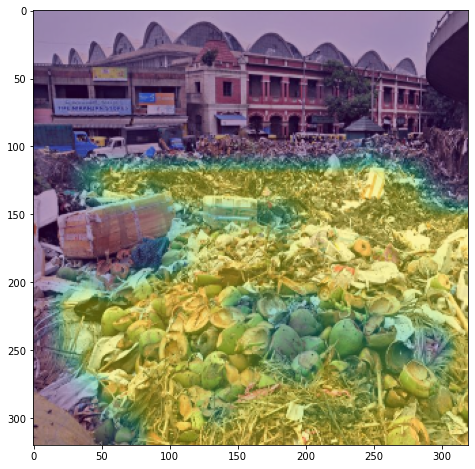

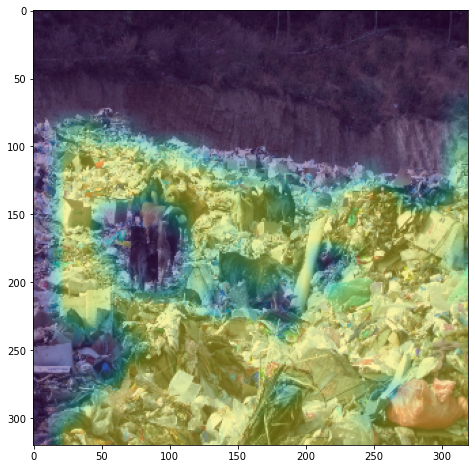

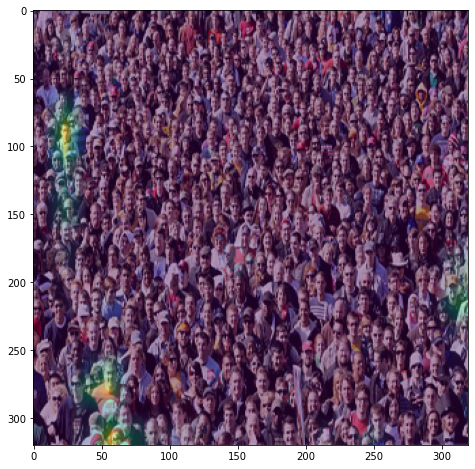

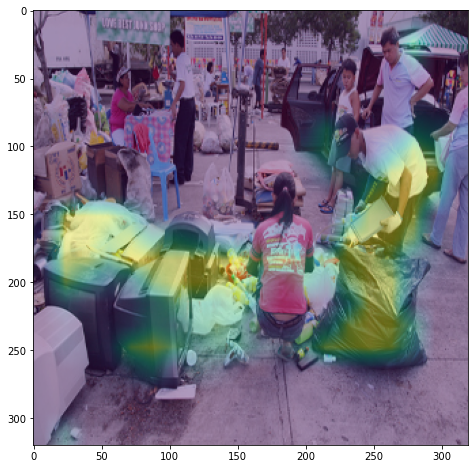

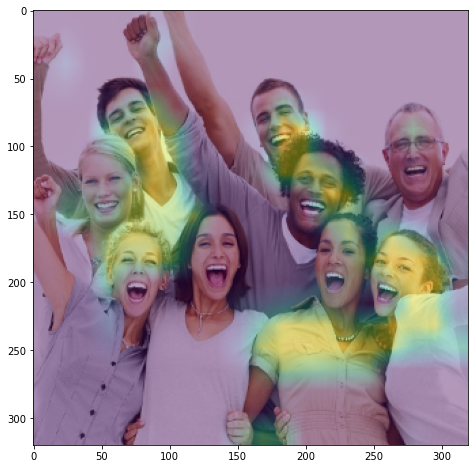

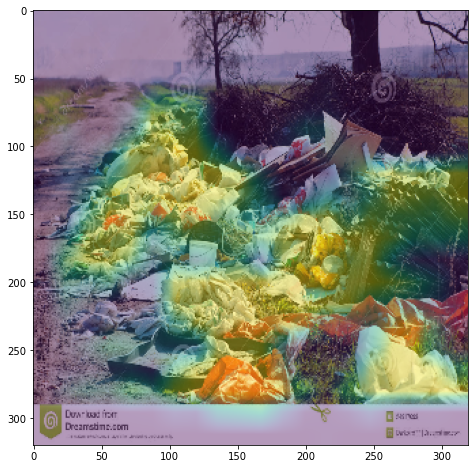

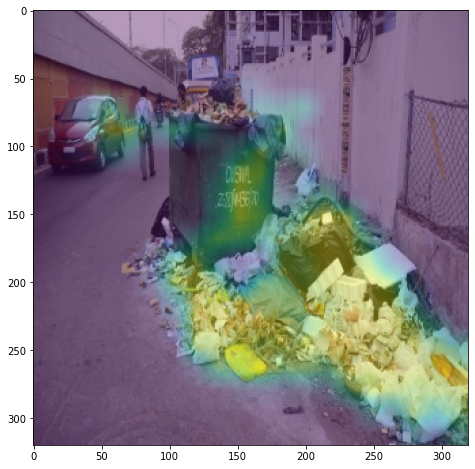

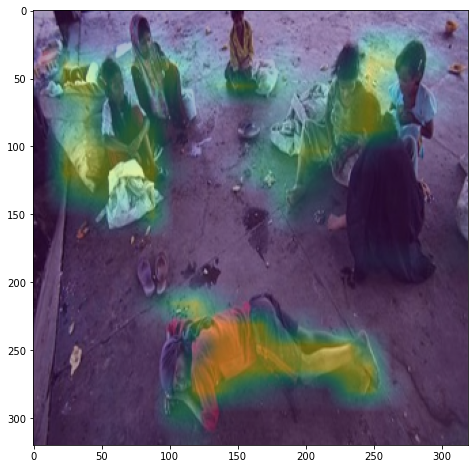

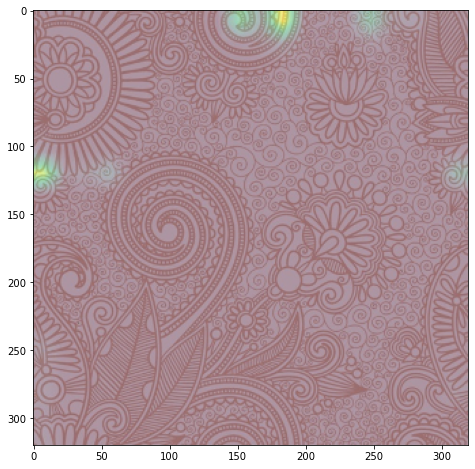

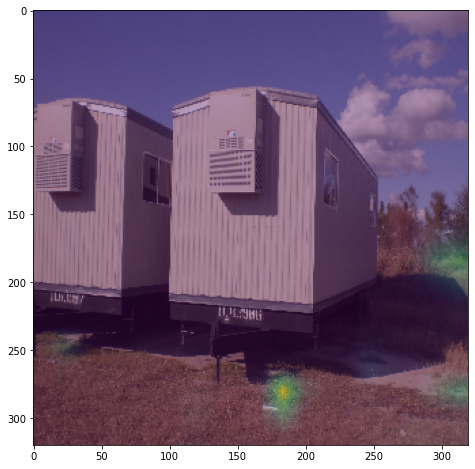

In [16]:
for fp in os.listdir(DIR)[60:70]:
    mask_garbage(DIR+fp, show=True, save=False, resize=True)

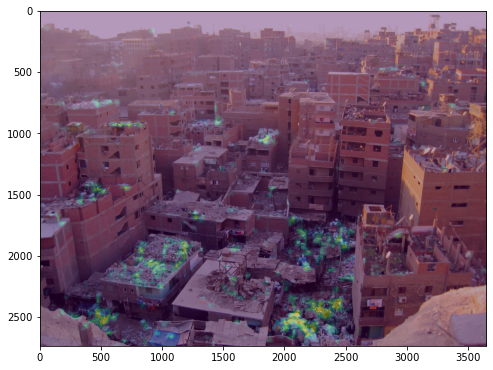

In [17]:
mask_garbage(DIR+'../train/3adba2c8-6799-11e5-8dc4-40f2e96c8ad8.jpg', show=True, resize=False)

In [37]:
finp = tf.keras.layers.Input(shape=(320,320,3))

In [38]:
fmodel = tf.keras.models.Sequential([finp, model])

In [39]:
fmodel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_1 (Functional)    (None, None, None, 1)     712441    
Total params: 712,441
Trainable params: 702,761
Non-trainable params: 9,680
_________________________________________________________________


In [40]:
converter = tf.lite.TFLiteConverter.from_keras_model(fmodel)

In [41]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]

In [42]:
# # For full integer quantization, you need to measure the dynamic range of activations and inputs by supplying
# # sample input data to the converter.
# def representative_dataset_gen():
#     for _ in range(num_calibration_steps):
#         # Get sample input data as a numpy array in a method of your choosing.
#         yield [input]
# converter.representative_dataset = representative_dataset_gen

In [43]:
converter.target_spec.supported_types = [tf.float32] # [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

In [44]:
# Full integer for coral edge
# converter.inference_input_type = tf.uint8
# converter.inference_output_type = tf.uint8

In [45]:
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp__j2m2hl/assets


INFO:tensorflow:Assets written to: /tmp/tmp__j2m2hl/assets


In [46]:
tflite_path = 'new_model_0_75/my_model_fp32.tflite'

In [47]:
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)

# Steps to run are below

In [31]:
tflite_interpreter = tf.lite.Interpreter(model_path=tflite_path)

In [32]:
tflite_interpreter.allocate_tensors()

In [33]:
tflite_input_details = tflite_interpreter.get_input_details()
tflite_input_details

[{'name': 'input_1',
  'index': 0,
  'shape': array([  1, 320, 320,   3], dtype=int32),
  'shape_signature': array([ -1, 320, 320,   3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [34]:
tflite_output_details = tflite_interpreter.get_output_details()
tflite_output_details

[{'name': 'Identity',
  'index': 331,
  'shape': array([ 1, 20, 20,  1], dtype=int32),
  'shape_signature': array([-1, 20, 20,  1], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [36]:
img = cv2.imread(DIR+'../train/3adba2c8-6799-11e5-8dc4-40f2e96c8ad8.jpg')
img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
img = img/255#127.5 - 1

In [37]:
tflite_interpreter.set_tensor(tflite_input_details[0]['index'], np.expand_dims(img, axis=0))

In [38]:
tflite_interpreter.invoke()

In [39]:
out = tflite_interpreter.get_tensor(tflite_output_details[0]['index'])

In [40]:
from time import time

In [41]:
for i in range(100):
    start = time()
    tflite_interpreter.set_tensor(tflite_input_details[0]['index'], np.expand_dims(img, axis=0))
    tflite_interpreter.invoke()
    out = tflite_interpreter.get_tensor(tflite_output_details[0]['index'])
    print(time()-start)

0.030352115631103516
0.026998519897460938
0.02198934555053711
0.021114826202392578
0.020841121673583984
0.021548748016357422
0.020982742309570312
0.020480632781982422
0.021355390548706055
0.02067875862121582
0.027442455291748047
0.022208213806152344
0.02128148078918457
0.020737648010253906
0.020956993103027344
0.022911548614501953
0.02128148078918457
0.020780563354492188
0.021460294723510742
0.020999431610107422
0.021851778030395508
0.02733325958251953
0.021263837814331055
0.02131962776184082
0.021390438079833984
0.020925045013427734
0.02094554901123047
0.02134251594543457
0.02156209945678711
0.02123403549194336
0.0218508243560791
0.026079177856445312
0.021355628967285156
0.021906137466430664
0.020823001861572266
0.020543575286865234
0.020919084548950195
0.021342754364013672
0.022404193878173828
0.021901369094848633
0.026149988174438477
0.025474071502685547
0.021611690521240234
0.02125263214111328
0.02069091796875
0.021474838256835938
0.021543025970458984
0.020808696746826172
0.0206480

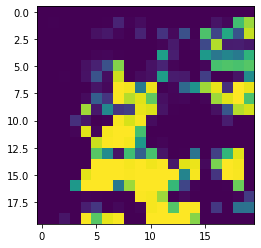

In [42]:
plt.imshow(out.squeeze())